In [1]:
#preliminary definitions

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from io import StringIO
import io

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.constants import G, h, k_B


#imported requests
import requests

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"bc47cc6e1bd83ad2708bc714f126dc09"}

#defined get()
def get(path, params=None):
    # make HTTP GET request to path
    headers = {"api-key":"bc47cc6e1bd83ad2708bc714f126dc09"}
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r


In [2]:
#input params: redshift==numerical-val; id==int(must exist); plot=="True" or "False"
def LookbackTime_hist(redshift, id, plot): 
    h = 0.6774
    cosmo = FlatLambdaCDM(H0= (h * 100) * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
    
    import h5py
    params = {'stars':'GFM_StellarFormationTime,GFM_InitialMass'}
#if exists, load it. If does not exist, download it

    from pathlib import Path

    if Path('cutout_'+str(id)+'.hdf5').is_file():
        saved_filename = 'cutout_'+str(id)+'.hdf5'
        #print ("File exist") #extract if exists
        with h5py.File(saved_filename, mode='r') as f: #store as h5py file
            starFormationTime = f['PartType4']['GFM_StellarFormationTime'][:]
            starInitialMass = f['PartType4']['GFM_InitialMass'][:]
    else:
        #print ("File not exist") #download and extract if does not exist
        url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
        sub = get(url) # get json response of subhalo properties
        saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file
    
        with h5py.File(saved_filename, mode='r') as f: #store as h5py file
            starFormationTime = f['PartType4']['GFM_StellarFormationTime'][:]
            starInitialMass = f['PartType4']['GFM_InitialMass'][:]
        
    
    z_starFormationTime = 1/starFormationTime -1
    Gyr_starFormationTime = cosmo.age(z_starFormationTime).value
    M_Odot_starInitialMass = starInitialMass*1e10/h 
    Gyr_redshift = cosmo.age(2.0).value
    binwidth = (min(Gyr_starFormationTime) + max(Gyr_starFormationTime))/150
    StellarFormationRate = M_Odot_starInitialMass/(binwidth*1e9)
    LookbackTime = Gyr_redshift - Gyr_starFormationTime
    
    if plot==True:
        plt.figure(figsize=(10,7))
        plt.title('Histogram for Lookback Times for id = ' + str(id))
        plt.xlim(0, Gyr_redshift)
        plt.hist(LookbackTime, bins=np.arange(min(Gyr_redshift - Gyr_starFormationTime), max(Gyr_redshift - Gyr_starFormationTime) + binwidth, binwidth), weights=(StellarFormationRate), histtype="step")
        plt.xlabel("Lookback Time (Gyr)")
        plt.ylabel("$M_\odot$/yr")

        return plt.hist
    
    else:
        return [StellarFormationRate, LookbackTime]

C:\Users\debos\anaconda3\lib\site-packages\astropy\cosmology\core.py:1170: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  red, np.inf)[0]
C:\Users\debos\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


<function matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)>

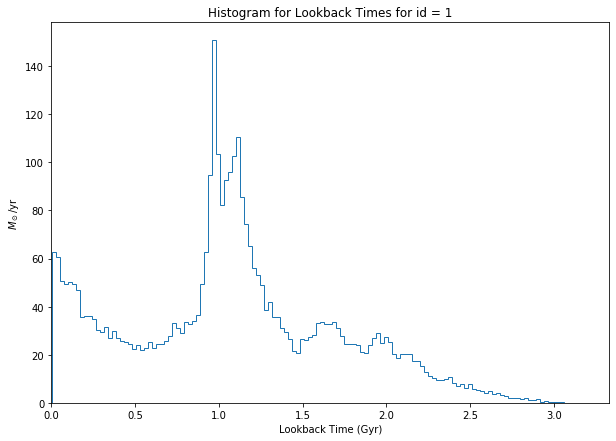

In [3]:
LookbackTime_hist(redshift = 2.0, id = 1, plot=True)
#[1, 11772, 21763, 33046, 95902, 132063, 162854, 192865, 243568, 297207]

In [4]:
def Mean_Stellar_Age(z, subhalo_id):
    SFR, LT = LookbackTime_hist(redshift = z, id = subhalo_id, plot=False)
    
    numerator = [SFR[i]*LT[i]*1e9 for i in range(len(SFR))]
    numerator = np.around(numerator)
    numerator = numerator.astype(int)
    MeanStellarAge = sum(numerator)/sum(SFR*1e9)
    
    return print("Mean Stellar Age for subhalo with id=" +str(subhalo_id)+ " at redshift " + str(z) + " is " + str(MeanStellarAge) + " Gyr")

In [6]:
Mean_Stellar_Age(z=2.0, subhalo_id=1)
#I don't think this result makes sense, but am not sure what the mistake is :(

Mean Stellar Age for subhalo with id=1 at redshift 2.0 is 0.00046508570062344875 Gyr


C:\Users\debos\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in long_scalars
  import sys
